# Iris dataset - Regressão Logística - 3 classes

## Objetivos

Este notebook ilustra o problema de classificação.

O objetivo é classificar as amostras da Íris em 3 classes.
- o alvo é o índice da classe: 0, 1 ou 2
- função de perda é Entropia Cruzada
- rede é uma camada densa linear com duas entradas e três saídas (n. de classes)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmax_CrossEntropy_Otimizacao.png)

## Importação das bibliotecas

In [1]:
%matplotlib inline
import os
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

from IPython import display

## Dataset: Leitura, normalização e visualização dos dados

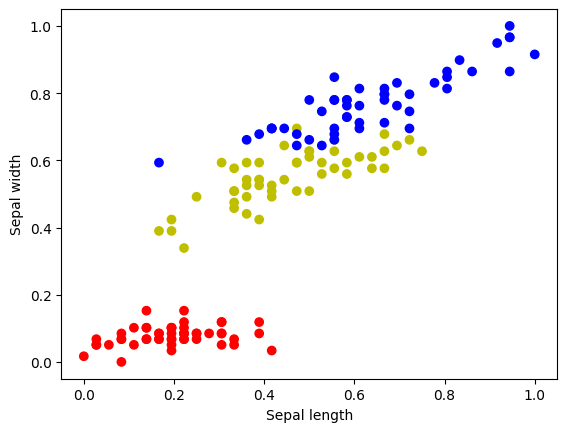

In [2]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
# normalização
Xc = X - X.min(axis=0)
Xs = Xc.max(axis=0)
Xc = Xc/Xs

Y = iris.target
colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)  # Entrada é FloatTensor
Y_tensor = torch.LongTensor(Y)    # Classe é LongTensor

In [4]:
Y_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Construindo o modelo da rede

A saída da rede é composta por um neurônio para cada classe. A saída é denominada *scores* ou logitos:

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLogisticaRede_2_3.png)

In [5]:
model = nn.Linear(2,3)  # 2 entradas e 3 saídas

In [6]:
model.state_dict()

OrderedDict([('weight',
              tensor([[-0.4908,  0.1205],
                      [-0.0144, -0.2491],
                      [ 0.3954,  0.2111]])),
             ('bias', tensor([-0.1613, -0.4599,  0.1533]))])

### Fazendo um predict

In [7]:
out = model(Variable(X_tensor[:4,:])) # 4 amostras
out

tensor([[-0.2622, -0.4800,  0.2555],
        [-0.2350, -0.4792,  0.2335],
        [-0.2097, -0.4742,  0.2080],
        [-0.1920, -0.4822,  0.2042]], grad_fn=<AddmmBackward0>)

In [8]:
oo = F.softmax(out,dim=1)
oo

tensor([[0.2871, 0.2310, 0.4819],
        [0.2958, 0.2317, 0.4725],
        [0.3043, 0.2336, 0.4621],
        [0.3092, 0.2313, 0.4595]], grad_fn=<SoftmaxBackward0>)

### Calculando as probabilidades com Softmax

- [Wikipedia:Softmax_function](https://en.wikipedia.org/wiki/Softmax_function)

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/softmax.png)

In [9]:
F.softmax(out,dim=1)*100

tensor([[28.7146, 23.0956, 48.1899],
        [29.5777, 23.1685, 47.2538],
        [30.4305, 23.3599, 46.2096],
        [30.9188, 23.1310, 45.9502]], grad_fn=<MulBackward0>)

### Predição da classe

In [10]:
prob,y_pred = torch.max(F.softmax(out,dim=1),dim=1)
print(y_pred)
print(prob)

tensor([2, 2, 2, 2])
tensor([0.4819, 0.4725, 0.4621, 0.4595], grad_fn=<MaxBackward0>)


## Treinamento

### Classe para visualização dinâmica

In [11]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

def predict_prob(model, inputs):
    outputs = model(Variable(inputs))
    outputs = F.softmax(outputs,dim=1)
    predicts, _ = torch.max(outputs, 1)

    return predicts.data.numpy()

class MyPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(12, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 3, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.set_title('Perda x Época')
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 3, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax2.set_title('Fronteiras de decisão')

        self.ax3 = self.fig.add_subplot(1, 3, 3)
        self.ax3.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax3.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax3.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax3.set_ylabel('Largura da Sepala')#,fontsize=28)
        self.ax3.set_title('Máxima probabilidade')

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            #if epoch%250==0:
            if epoch%1000==999:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                #Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
                Zc = predict(self.model,torch.FloatTensor(self.X_grid))
                Zc = Zc.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Zc, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                Zp = predict_prob(self.model,torch.FloatTensor(self.X_grid))
                Zp = Zp.reshape(self.xx.shape)

                self.ax3.pcolormesh(self.xx, self.yy, Zp, cmap=plt.cm.magma)
                colors = np.array(['r','y','b'])
                self.ax3.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

### Laço principal de treinamento da Regressão Logística por Softmax

In [12]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Final loss: 0.20754607021808624


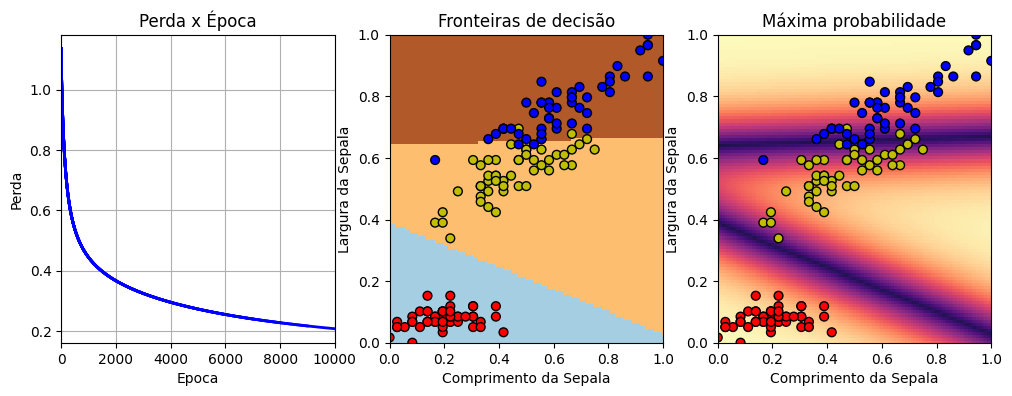

In [13]:
nb_epoch = 10000

#Definindo o plotter
my_plot = MyPlotter(model, Xc, Y, nb_epoch)

losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    # calcula a perda
    loss = criterion(output, Variable(Y_tensor))

    # Faz o backpropagation para calcular os gradientes e otimizar parâmetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data.item())

    my_plot.on_epoch_end(i, {'loss': loss.data.item()});
    final_loss = loss.data.item()

print('Final loss:', final_loss)

## Avaliação

### Parâmetros após treinamento

In [14]:
model.state_dict()

OrderedDict([('weight',
              tensor([[ -3.2308, -14.6149],
                      [  1.7961,  -0.6557],
                      [  1.3249,  15.3530]])),
             ('bias', tensor([ 6.8766,  1.4538, -8.7983]))])

### Salvando os parâmetros treinados

In [15]:
os.makedirs('../models',exist_ok=True)
torch.save(model.state_dict(),'../models/RegrLog_Iris.pt')

In [16]:
! ls ../models/

RegrLog_Iris.pt


In [17]:
nn.init.constant(model.weight,0)
model.state_dict()

<ipython-input-17-0d5512203613>:1: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(model.weight,0)


OrderedDict([('weight',
              tensor([[0., 0.],
                      [0., 0.],
                      [0., 0.]])),
             ('bias', tensor([ 6.8766,  1.4538, -8.7983]))])

### Recuperando os pesos salvos

In [18]:
param_saved = torch.load('../models/RegrLog_Iris.pt')
model.load_state_dict(param_saved)
model.state_dict()

<ipython-input-18-079748b01dc8>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  param_saved = torch.load('../models/RegrLog_Iris.pt')


OrderedDict([('weight',
              tensor([[ -3.2308, -14.6149],
                      [  1.7961,  -0.6557],
                      [  1.3249,  15.3530]])),
             ('bias', tensor([ 6.8766,  1.4538, -8.7983]))])

### Exatidão (acurácia) do classificador

Acurácia indica o número de acertos sobre o número total de amostras

In [19]:
Y_pred = predict(model, X_tensor)
accuracy = (Y_pred == Y).mean()
print('Training Accuracy: ', accuracy)

Training Accuracy:  0.96


### Matriz de confusão

In [20]:
import pandas as pd
pd.crosstab(Y_pred, Y)

col_0,0,1,2
row_0,,,
0,50,0,0
1,0,47,3
2,0,3,47


## Atividades

### Perguntas:

1. Observe que se após o treinamento, a célula for executada novamente, ela continua utilizando os parâmetros treinados até sua última execução. O que é preciso fazer para que o treinamento comece deste o início, como da primeira vez que foi executado?

**R:** Deve-se reiniciar os pesos e bias da rede e redefinir o otimizador, através de uma nova instância, para garantir que os gradientes também sejam reiniciados.

2. Experimente refazer o treinamento com diferentes valores de learning rate.

**R:** Percebe-se que ao aumentar o learning rate o modelo consegue chegar mais próximo rapidamente do valor ideal, com perdas pequenas. Para esta base, observou-se que é necessário um alto learning rate (acima de 500) para que o modelo divergisse e aumentasse a perda, porém ainda é possível perceber que ele se recupera em seguida.

### Exercícios:

1. Observando o gráfico de máxima probabilidade, responda:
    1. Qual é a amostra classificada corretamente, com maior probabilidade?

    **R:** Amostras classificadas corretamente com maior probabilidade são as que estão nas áreas mais claras (amarelas) do gráfico. Percebe-se que algumas amostras azuis (virgínicas) e praticamente todas as vermelhas (setosas) estão mais distantes da fronteira de decisão. A probabilidade máxima, neste caso, é de 99,51% para a classe 2.

    **Obs:** estes valores podem variar de acordo com a execução e o valor do learning rate (ver código abaixo)
    
    2. Qual é a amostra classificada erradamente, com maior probabilidade?
    
    **R:** Amostras classificadas erroneamente estão fora da área dde cobertura da classe correspondente e quanto mais situada nas áreas mais claras, maior a probabilidade do erro. A probabilidade de classificação errada com maior probabilidade correspondente a 68,41% para uma classe 2 e que foi classeificada como 1 (ver código a seguir)

    3. Qual é a amostra classificada corretamente, com menor probabilidade?

    **R:** As amostras classificadas corretamente, mas com menos probabilidade estão situadas próximas à fronteira de decisão (área mais escura do gráfico). A amostra classificada corretamente com menor probabilidade pertence à classe 1 e obteve 50,41% de probabilidade.

    4. Qual é a amostra classificada erradamente, com menor probabilidade?

    **R:** As amostras classificadas erradamente e com menor probabilidade também estão próximas à fronteira de decisão. Neste caso, obteve-se uma probabilidade de 51,65% para uma classe tipo 1 que foi classificada erroneamente como tipo 2.

2. Quantos parâmetros possui esta rede? Quantos são da camada densa e quantos são de bias?

**R:** Esta rede possui 2 x 3 + 3 = 9 parâmetros, sendo 6 da camada densa (pesos) e 3 de bias (para cada classe/saída possível).

3. Quantas entradas e quantas saídas esta rede possui?

**R:** Duas entradas (não considerando bias) e três saídas (para cada uma das classes da classificação)

4. Como se pode calcular a acurácia a partir da matriz de confusão?

**R:** A acurácia pela matriz de confusão é calculada dividindo a soma dos valore da diagonal principal (verdadeiros positivos) pela soma de todos os elementos da matriz de confusão (total de amostras).

5. O que faz a função `torch.max`? Quantos parâmetros ela retorna e quais seus significados?
    - http://pytorch.org/docs/master/torch.html?highlight=torch%20max#torch.max

**R:** O método torch.max retorna o valor máximo em um tensor ao longo de uma dimensão específica e também o índice correspondente à posição no tensor onde este valor máximo ocorre. O valor máximo obtido é utilizado para definir a maior probabilidade predita entre todas as saídas e o índice é utilizado para identificar qual é a classe correspondente ao valor máximo e que definirá o valor final da predição.

In [21]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [22]:
pred = model(Variable(X_tensor))
prob, y_prob = torch.max(F.softmax(pred,dim=1),dim=1)

In [23]:
mask_correct = (y_prob == Y_tensor)
prob_correct = prob[mask_correct]

prob_max = prob_correct.max()
idx_max = torch.where(prob == prob_max)[0]  # Índice da amostra com maior probabilidade correta
print(f'1.1. Amostra classificada corretamente, com maior probabilidade:')
for idx in idx_max:
  if y_prob[idx].item() == Y_tensor[idx].item():
    print(f'      Índice: {idx.item()}, Probabilidade: {prob_max.item():.4f}, Classe predita: {y_prob[idx].item()}, Classe real: {Y_tensor[idx].item()}')

1.1. Amostra classificada corretamente, com maior probabilidade:
      Índice: 118, Probabilidade: 0.9951, Classe predita: 2, Classe real: 2


In [24]:
mask_wrong = (y_prob != Y_tensor)
prob_wrong = prob[mask_wrong]

prob_max = prob_wrong.max()
idx_max = torch.where(prob == prob_max)[0]  # Índice da amostra com maior probabilidade errada
print(f'1.2. Amostra classificada erradamente, com maior probabilidade:')
for idx in idx_max:
  if y_prob[idx].item() != Y_tensor[idx].item():
    print(f'      Índice: {idx.item()}, Probabilidade: {prob_max.item():.4f}, Classe predita: {y_prob[idx].item()}, Classe real: {Y_tensor[idx].item()}')

1.2. Amostra classificada erradamente, com maior probabilidade:
      Índice: 106, Probabilidade: 0.6853, Classe predita: 1, Classe real: 2


In [25]:
prob_min = prob_correct.min()
idx_min = torch.where(prob == prob_min)[0]  # Índice da amostra com maior probabilidade correta
print(f'1.3. Amostra classificada corretamente, com menor probabilidade:')
for idx in idx_min:
  if y_prob[idx].item() == Y_tensor[idx].item():
    print(f'      Índice: {idx.item()}, Probabilidade: {prob_min.item():.4f}, Classe predita: {y_prob[idx].item()}, Classe real: {Y_tensor[idx].item()}')

1.3. Amostra classificada corretamente, com menor probabilidade:
      Índice: 52, Probabilidade: 0.5025, Classe predita: 1, Classe real: 1


In [26]:
prob_min = prob_wrong.min()
idx_min = torch.where(prob == prob_min)[0]  # Índice da amostra com maior probabilidade errada
print(f'1.4. Amostra classificada erradamente, com menor probabilidade:')
for idx in idx_min:
  if y_prob[idx].item() != Y_tensor[idx].item():
    print(f'      Índice: {idx.item()}, Probabilidade: {prob_min.item():.4f}, Classe predita: {y_prob[idx].item()}, Classe real: {Y_tensor[idx].item()}')

1.4. Amostra classificada erradamente, com menor probabilidade:
      Índice: 72, Probabilidade: 0.5167, Classe predita: 2, Classe real: 1


## Principais aprendizados